In [1]:
%pip install pandas numpy scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib as plt

In [3]:
file_path = '/Users/marcoayuob/RR_project/Final Data -EPL_Cleaned_2000_to_2025.csv'
#file_path = '/Users/akshma/Documents/DS/semester4/RR/RRprojectrepo/RR_project/Final Data -EPL_Cleaned_2000_to_2025.csv'
df = pd.read_csv(file_path)

In [4]:
df.head(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 27 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Div       9440 non-null   object 
 1   Date      5878 non-null   object 
 2   HomeTeam  9440 non-null   object 
 3   AwayTeam  9440 non-null   object 
 4   FTHG      9440 non-null   int64  
 5   FTAG      9440 non-null   int64  
 6   FTR       9440 non-null   object 
 7   HTHG      9440 non-null   int64  
 8   HTAG      9440 non-null   int64  
 9   HTR       9440 non-null   object 
 10  Referee   9440 non-null   object 
 11  HS        9440 non-null   int64  
 12  AS        9440 non-null   int64  
 13  HST       9440 non-null   int64  
 14  AST       9440 non-null   int64  
 15  HC        9440 non-null   int64  
 16  AC        9440 non-null   int64  
 17  HF        9440 non-null   int64  
 18  AF        9440 non-null   int64  
 19  HY        9440 non-null   int64  
 20  AY        9440 non-null   int6

(  Div        Date  HomeTeam       AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR  \
 0  E0  2000-08-19  Charlton       Man City     4     0   H     2     0   H   
 1  E0  2000-08-19   Chelsea       West Ham     4     2   H     1     0   H   
 2  E0  2000-08-19  Coventry  Middlesbrough     1     3   A     1     1   D   
 3  E0  2000-08-19     Derby    Southampton     2     2   D     1     2   A   
 4  E0  2000-08-19     Leeds        Everton     2     0   H     2     0   H   
 
    ...  HF  AF  HY  AY  HR  AR   WHH  WHD   WHA  Season  
 0  ...  13  12   1   2   0   0  2.10  3.2  3.10   00-01  
 1  ...  19  14   1   2   0   0  1.44  3.6  6.50   00-01  
 2  ...  15  21   5   3   1   0  2.30  3.2  2.62   00-01  
 3  ...  11  13   1   1   0   0  2.00  3.2  3.20   00-01  
 4  ...  21  20   1   3   0   0  1.61  3.5  4.50   00-01  
 
 [5 rows x 27 columns],
 None)

In [5]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date'])

In [6]:
#handling missing data
for col in ['WHH', 'WHD', 'WHA']:
    df[col] = df[col].fillna(df[col].median())

In [7]:
#new column-goal difference
df['GoalDiff'] = df['FTHG'] - df['FTAG']  
df['MatchResult'] = df['FTR'].map({'H': 1, 'D': 0, 'A': -1}) 

In [8]:
# Extract date parts
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek

In [9]:
categorical_cols = ['HomeTeam', 'AwayTeam', 'Referee', 'Season']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [10]:
duplicates = df.duplicated().sum()


In [11]:
df = df.sort_values(['HomeTeam', 'Date'])

In [12]:
# Home team averages
df['HomeTeam_Goals_Last5'] = (
    df.groupby('HomeTeam')['FTHG'].transform(lambda x: x.rolling(5, min_periods=1).mean())
)
df['HomeTeam_Concede_Last5'] = (
    df.groupby('HomeTeam')['FTAG'].transform(lambda x: x.rolling(5, min_periods=1).mean())
)

In [13]:
# Away team averages
df = df.sort_values(['AwayTeam', 'Date'])
df['AwayTeam_Goals_Last5'] = (
    df.groupby('AwayTeam')['FTAG'].transform(lambda x: x.rolling(5, min_periods=1).mean())
)
df['AwayTeam_Concede_Last5'] = (
    df.groupby('AwayTeam')['FTHG'].transform(lambda x: x.rolling(5, min_periods=1).mean())
)

In [14]:
# 4. Win streaks (last 5 games)
def win_streak(series):
    return (series == 'H').astype(int).rolling(5, min_periods=1).sum()

df = df.sort_values(['HomeTeam', 'Date'])
df['Home_WinStreak_Last5'] = (
    df.groupby('HomeTeam')['FTR'].transform(win_streak)
)

df = df.sort_values(['AwayTeam', 'Date'])
df['Away_WinStreak_Last5'] = (
    df.groupby('AwayTeam')['FTR'].transform(lambda x: (x == 'A').astype(int).rolling(5, min_periods=1).sum())
)



In [15]:
df = df.dropna()

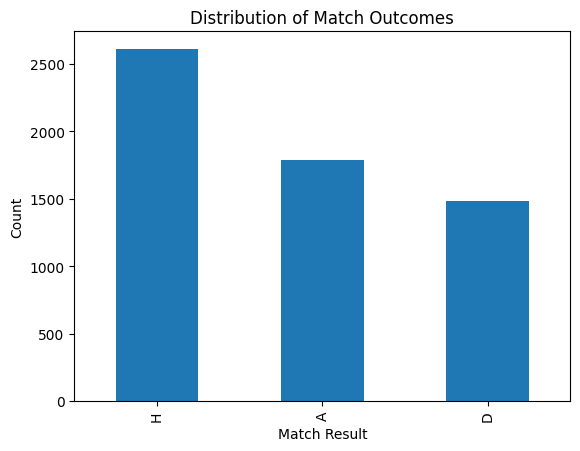

In [16]:
# Plot: Match outcome distribution
import matplotlib.pyplot as plt
df['FTR'].value_counts().plot(kind='bar')
plt.title('Distribution of Match Outcomes')
plt.xlabel('Match Result')
plt.ylabel('Count')
plt.show()

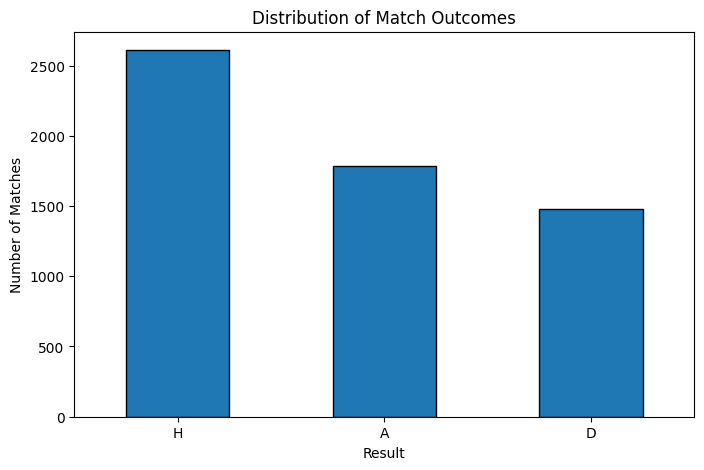

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Match Outcome Distribution
plt.figure(figsize=(8, 5))
df['FTR'].value_counts().plot(kind='bar', edgecolor='black')
plt.title('Distribution of Match Outcomes')
plt.xlabel('Result')
plt.ylabel('Number of Matches')
plt.xticks(rotation=0)
plt.show()

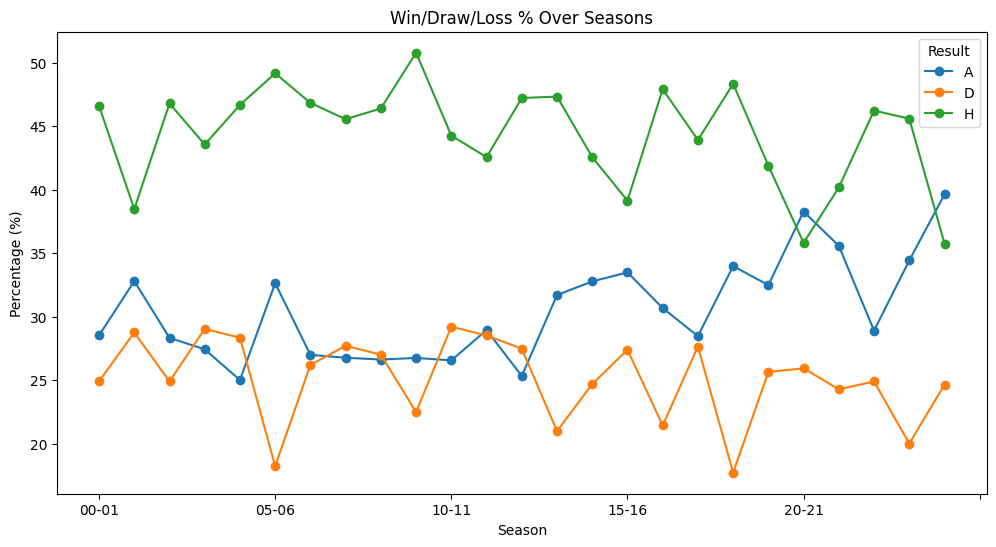

In [18]:
# Match Outcomes Over Seasons
season_outcomes = df.groupby('Season')['FTR'].value_counts(normalize=True).unstack().fillna(0) * 100
season_outcomes.plot(kind='line', marker='o', figsize=(12, 6))
plt.title('Win/Draw/Loss % Over Seasons')
plt.ylabel('Percentage (%)')
plt.xlabel('Season')
plt.legend(title='Result')
plt.show()

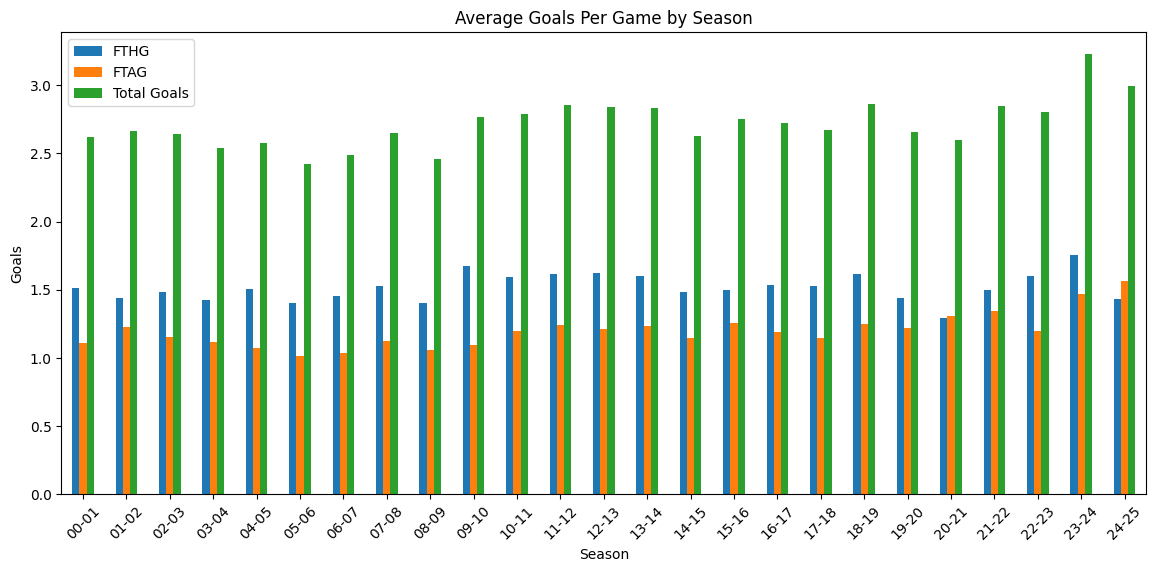

In [19]:
# Average Goals Per Game by Season
avg_goals = df.groupby('Season')[['FTHG', 'FTAG']].mean()
avg_goals['Total Goals'] = avg_goals['FTHG'] + avg_goals['FTAG']
avg_goals[['FTHG', 'FTAG', 'Total Goals']].plot(kind='bar', figsize=(14, 6))
plt.title('Average Goals Per Game by Season')
plt.ylabel('Goals')
plt.xticks(rotation=45)
plt.show()

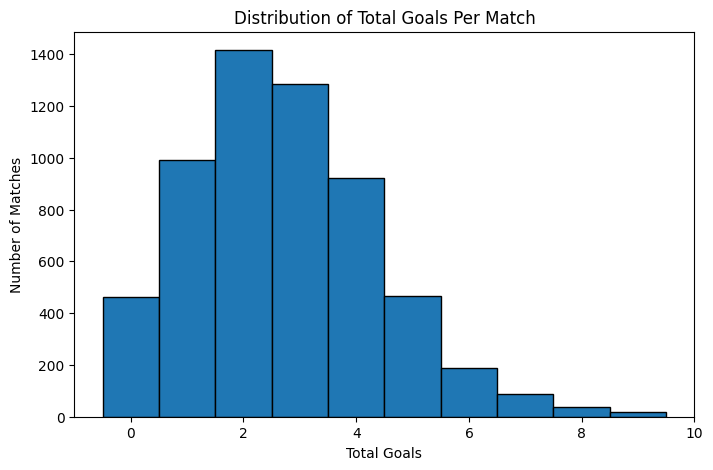

In [20]:
#Total Goals Per Match
df['TotalGoals'] = df['FTHG'] + df['FTAG']
plt.figure(figsize=(8, 5))
df['TotalGoals'].plot(kind='hist', bins=range(0, 11), edgecolor='black', align='left')
plt.title('Distribution of Total Goals Per Match')
plt.xlabel('Total Goals')
plt.ylabel('Number of Matches')
plt.show()

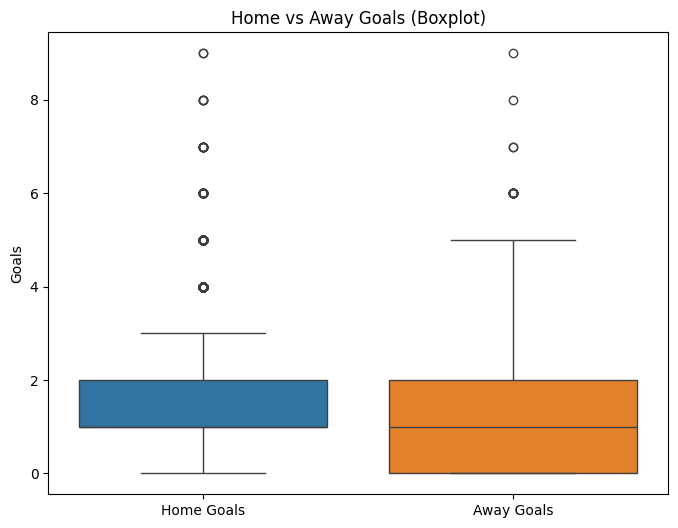

In [21]:
# Home vs Away Goals 
plt.figure(figsize=(8, 6))
sns.boxplot(data=df[['FTHG', 'FTAG']])
plt.title('Home vs Away Goals (Boxplot)')
plt.ylabel('Goals')
plt.xticks([0, 1], ['Home Goals', 'Away Goals'])
plt.show()

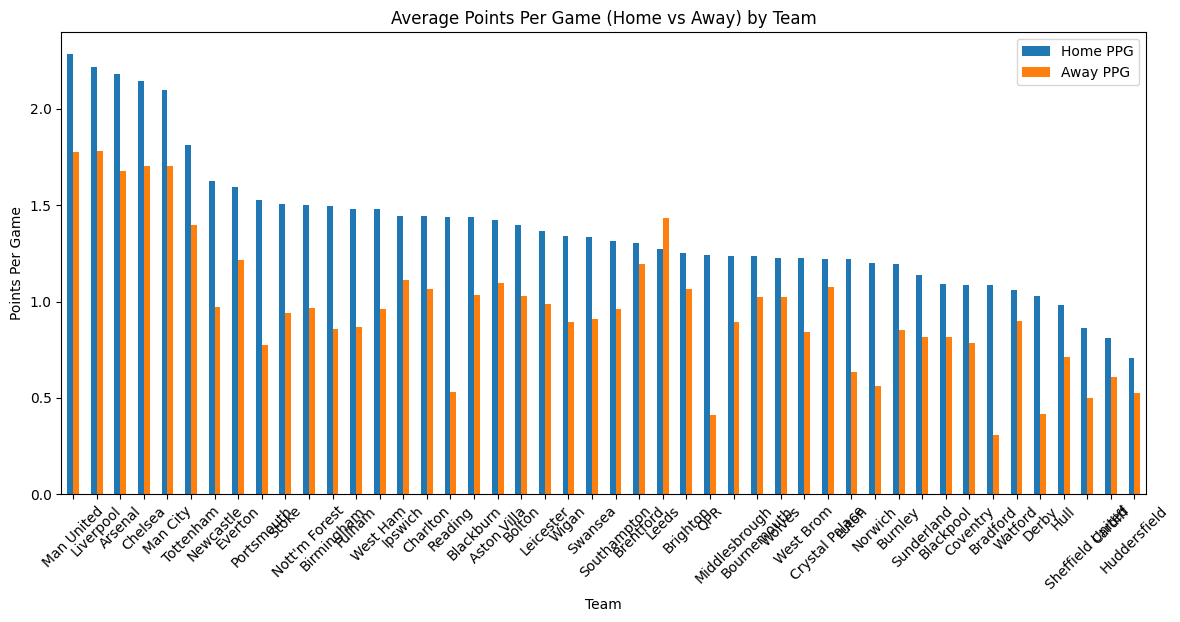

In [22]:
# Average Points Per Game (Home vs Away) by Team
df['HomePoints'] = df['FTR'].map({'H': 3, 'D': 1, 'A': 0})
df['AwayPoints'] = df['FTR'].map({'H': 0, 'D': 1, 'A': 3})

home_ppg = df.groupby('HomeTeam')['HomePoints'].mean().sort_values(ascending=False)
away_ppg = df.groupby('AwayTeam')['AwayPoints'].mean().sort_values(ascending=False)

ppg_df = pd.DataFrame({
    'Home PPG': home_ppg,
    'Away PPG': away_ppg
}).sort_values(by='Home PPG', ascending=False)

ppg_df.plot(kind='bar', figsize=(14, 6))
plt.title('Average Points Per Game (Home vs Away) by Team')
plt.ylabel('Points Per Game')
plt.xlabel('Team')
plt.xticks(rotation=45)
plt.show()

/var/folders/d6/n6pspgm12mqdk124xkztz2pr0000gn/T/ipykernel_35054/944682588.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  season_goals = df.groupby('Season').apply(lambda x: (x['FTHG'] + x['FTAG']).sum())
/var/folders/d6/n6pspgm12mqdk124xkztz2pr0000gn/T/ipykernel_35054/944682588.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Season', y='Total Goals', data=season_goals_df, palette='Purples_d', edgecolor='black')


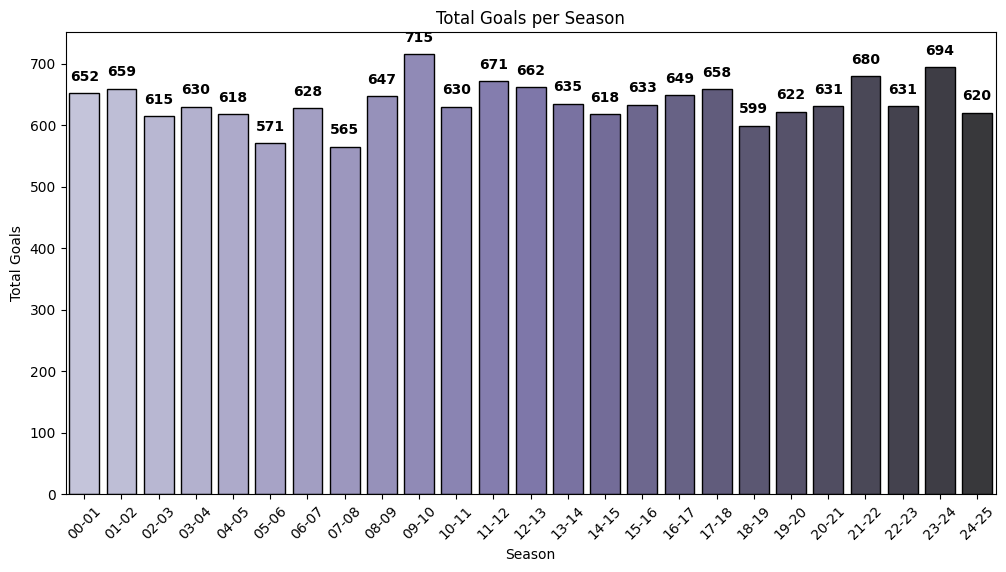

In [23]:
#Season with Most Total Goals
season_goals = df.groupby('Season').apply(lambda x: (x['FTHG'] + x['FTAG']).sum())
season_goals_df = season_goals.reset_index()
season_goals_df.columns = ['Season', 'Total Goals']
plt.figure(figsize=(12, 6))
sns.barplot(x='Season', y='Total Goals', data=season_goals_df, palette='Purples_d', edgecolor='black')
plt.title('Total Goals per Season')
plt.xlabel('Season')
plt.ylabel('Total Goals')
for i, v in enumerate(season_goals_df['Total Goals']):
    plt.text(i, v + 20, int(v), ha='center', fontweight='bold')
plt.xticks(rotation=45)
plt.show()

/var/folders/d6/n6pspgm12mqdk124xkztz2pr0000gn/T/ipykernel_35054/2073888045.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Team', y='Total Goals', data=total_goals_df, palette='Greens_d', edgecolor='black')


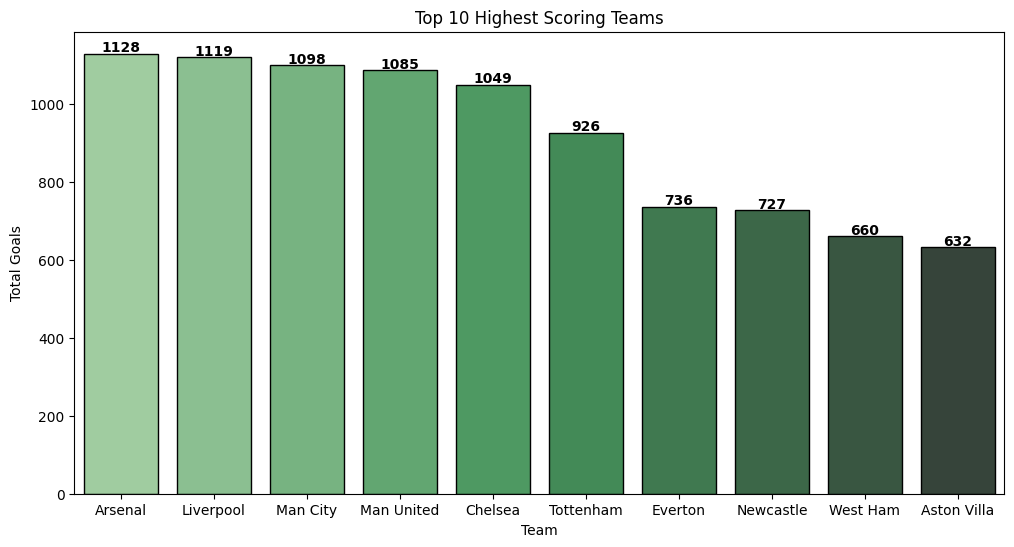

In [24]:

total_goals = df.groupby('HomeTeam')['FTHG'].sum() + df.groupby('AwayTeam')['FTAG'].sum()
total_goals_df = total_goals.sort_values(ascending=False).head(10).reset_index()
total_goals_df.columns = ['Team', 'Total Goals']
plt.figure(figsize=(12, 6))
sns.barplot(x='Team', y='Total Goals', data=total_goals_df, palette='Greens_d', edgecolor='black')
plt.title('Top 10 Highest Scoring Teams')
plt.xlabel('Team')
plt.ylabel('Total Goals')
for i, v in enumerate(total_goals_df['Total Goals']):
    plt.text(i, v + 5, int(v), ha='center', fontweight='bold')
plt.show()

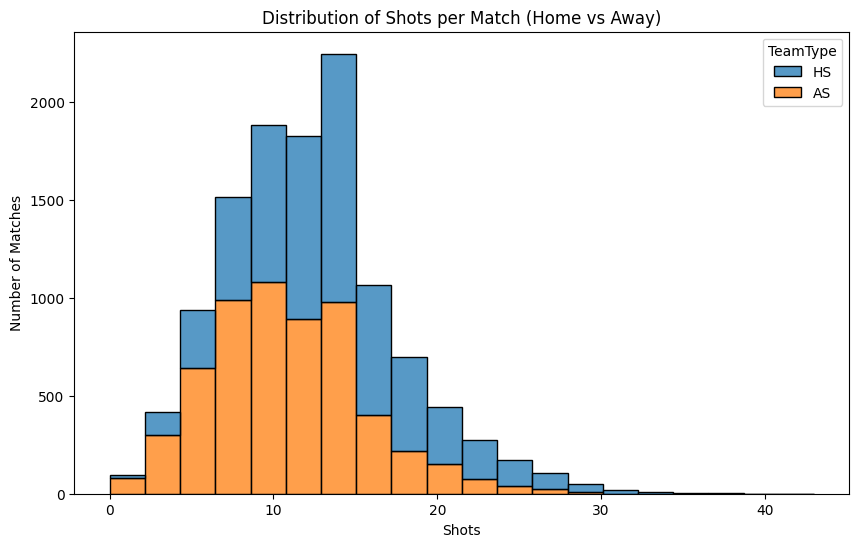

In [25]:
# Distribution of Shots per Match
shots_df = pd.melt(df[['HS', 'AS']], var_name='TeamType', value_name='Shots')
plt.figure(figsize=(10, 6))
sns.histplot(data=shots_df, x='Shots', hue='TeamType', multiple='stack', bins=20, edgecolor='black')
plt.title('Distribution of Shots per Match (Home vs Away)')
plt.xlabel('Shots')
plt.ylabel('Number of Matches')
plt.show()

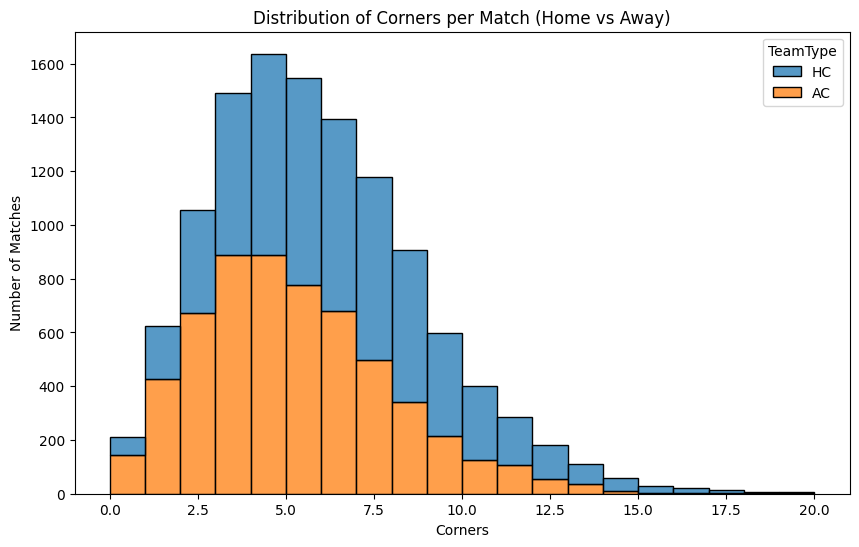

In [26]:
# Distribution of Corners per Match 
corners_df = pd.melt(df[['HC', 'AC']], var_name='TeamType', value_name='Corners')
plt.figure(figsize=(10, 6))
sns.histplot(data=corners_df, x='Corners', hue='TeamType', multiple='stack', bins=20, edgecolor='black')
plt.title('Distribution of Corners per Match (Home vs Away)')
plt.xlabel('Corners')
plt.ylabel('Number of Matches')
plt.show()

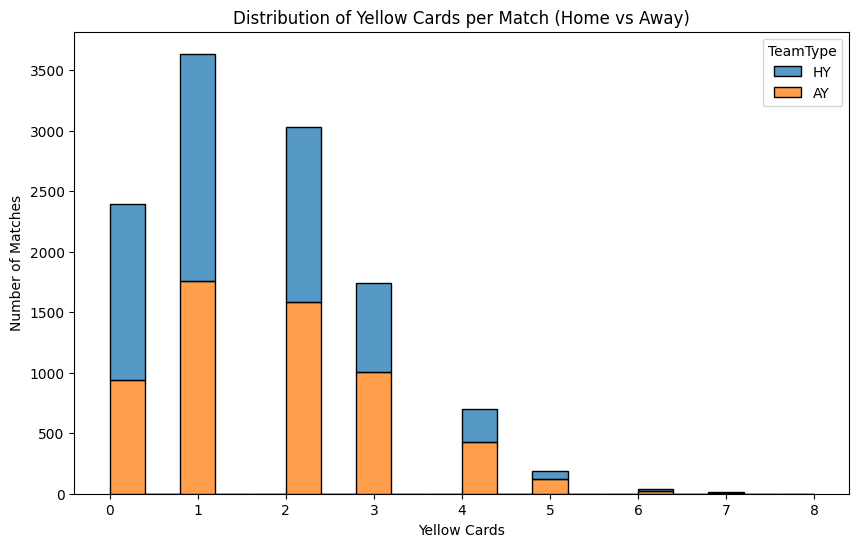

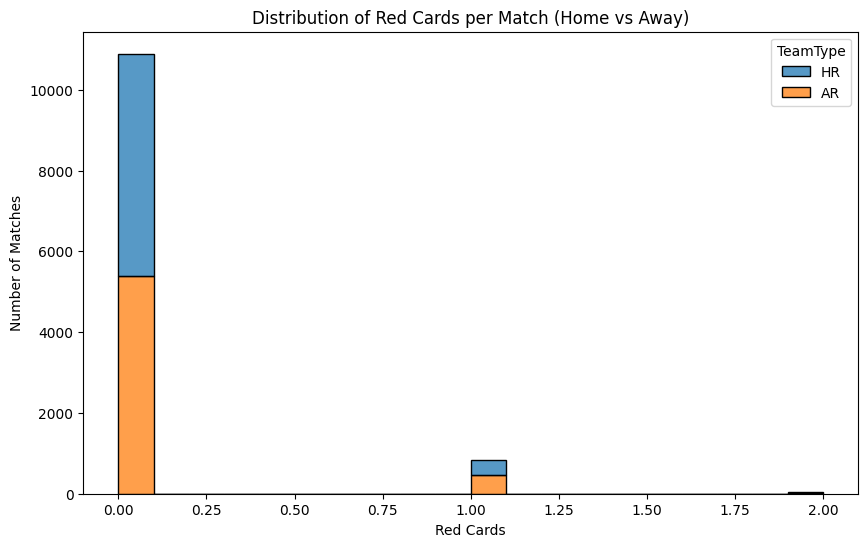

In [27]:
# distribution of yellow cards per match and red cards per match
yellow_cards_df = pd.melt(df[['HY', 'AY']], var_name='TeamType', value_name='Yellow Cards')
plt.figure(figsize=(10, 6))
sns.histplot(data=yellow_cards_df, x='Yellow Cards', hue='TeamType', multiple='stack', bins=20, edgecolor='black')
plt.title('Distribution of Yellow Cards per Match (Home vs Away)')
plt.xlabel('Yellow Cards')
plt.ylabel('Number of Matches')
plt.show()
red_cards_df = pd.melt(df[['HR', 'AR']], var_name='TeamType', value_name='Red Cards')
plt.figure(figsize=(10, 6))
sns.histplot(data=red_cards_df, x='Red Cards', hue='TeamType', multiple='stack', bins=20, edgecolor='black')
plt.title('Distribution of Red Cards per Match (Home vs Away)')
plt.xlabel('Red Cards')
plt.ylabel('Number of Matches')
plt.show()

In [28]:
print(df.dtypes)
print(df.isnull().sum())
print(duplicates)
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    print(f"{col}: {df[col].nunique()} unique values")

Div                               object
Date                      datetime64[ns]
HomeTeam                          object
AwayTeam                          object
FTHG                               int64
FTAG                               int64
FTR                               object
HTHG                               int64
HTAG                               int64
HTR                               object
Referee                           object
HS                                 int64
AS                                 int64
HST                                int64
AST                                int64
HC                                 int64
AC                                 int64
HF                                 int64
AF                                 int64
HY                                 int64
AY                                 int64
HR                                 int64
AR                                 int64
WHH                              float64
WHD             

In [29]:
selected_features = [
    'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR',
    'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR',
    'WHH', 'WHD', 'WHA', 'Season', 'GoalDiff', 'Year', 'Month', 'Day', 'DayOfWeek',
    'HomeTeam_Goals_Last5', 'HomeTeam_Concede_Last5',
    'AwayTeam_Goals_Last5', 'AwayTeam_Concede_Last5',
    'Home_WinStreak_Last5', 'Away_WinStreak_Last5', 'TotalGoals'
]

model_df = df[selected_features].copy()


In [30]:
model_df.head()


,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,...,Month,Day,DayOfWeek,HomeTeam_Goals_Last5,HomeTeam_Concede_Last5,AwayTeam_Goals_Last5,AwayTeam_Concede_Last5,Home_WinStreak_Last5,Away_WinStreak_Last5,TotalGoals
7,Sunderland,Arsenal,1,0,H,0,0,D,8,14,...,8,19,5,1.0,0.000000,0.00,1.00,1.0,0.0,1
47,Ipswich,Arsenal,1,1,D,0,0,D,17,10,...,9,23,5,1.0,0.666667,0.50,1.00,1.0,0.0,2
68,West Ham,Arsenal,1,2,A,0,2,A,11,13,...,10,21,5,1.0,1.400000,1.00,1.00,0.0,1.0,3
90,Everton,Arsenal,2,0,H,0,0,D,4,4,...,11,18,5,1.2,1.800000,0.75,1.25,1.0,1.0,2
104,Leeds,Arsenal,1,0,H,0,0,D,12,9,...,11,26,6,1.8,1.400000,0.60,1.20,3.0,1.0,1


In [31]:
label_map = {'H': 0, 'D': 1, 'A': 2}
model_df['MatchResult'] = df['FTR'].map(label_map)

In [32]:
model_df = model_df.drop(columns=['FTR'])
model_df.head()

,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,HTR,HS,AS,HST,...,Day,DayOfWeek,HomeTeam_Goals_Last5,HomeTeam_Concede_Last5,AwayTeam_Goals_Last5,AwayTeam_Concede_Last5,Home_WinStreak_Last5,Away_WinStreak_Last5,TotalGoals,MatchResult
7,Sunderland,Arsenal,1,0,0,0,D,8,14,2,...,19,5,1.0,0.000000,0.00,1.00,1.0,0.0,1,0
47,Ipswich,Arsenal,1,1,0,0,D,17,10,6,...,23,5,1.0,0.666667,0.50,1.00,1.0,0.0,2,1
68,West Ham,Arsenal,1,2,0,2,A,11,13,3,...,21,5,1.0,1.400000,1.00,1.00,0.0,1.0,3,2
90,Everton,Arsenal,2,0,0,0,D,4,4,2,...,18,5,1.2,1.800000,0.75,1.25,1.0,1.0,2,0
104,Leeds,Arsenal,1,0,0,0,D,12,9,6,...,26,6,1.8,1.400000,0.60,1.20,3.0,1.0,1,0


In [33]:
from sklearn.preprocessing import LabelEncoder
model_df = model_df.drop(columns=['Season'])
for col in model_df.select_dtypes(include='object').columns:
    model_df[col] = model_df[col].astype('category')
label_enc = LabelEncoder()
for col in model_df.select_dtypes(include='category').columns:
    model_df[col] = label_enc.fit_transform(model_df[col])
    

In [34]:
selected_features = [
    'HomeTeam', 'AwayTeam', 'HTHG', 'HTAG', 'HTR',
    'HS', 'AS', 'HST', 'AST', 'HC', 'AC',
    'HF', 'AF', 'HY', 'AY', 'HR', 'AR',
    'WHH', 'WHD', 'WHA',
    'Year', 'Month', 'Day', 'DayOfWeek',
    'HomeTeam_Goals_Last5', 'HomeTeam_Concede_Last5',
    'AwayTeam_Goals_Last5', 'AwayTeam_Concede_Last5',
    'Home_WinStreak_Last5', 'Away_WinStreak_Last5',
    'MatchResult'
]

model_df = model_df[selected_features].copy()

In [35]:
df_train = model_df[model_df['Year'] <= 2018].copy()
df_val = model_df[(model_df['Year'] >= 2019) & (model_df['Year'] <= 2022)].copy()
df_test = model_df[model_df['Year'] >= 2023].copy()

In [36]:
print("Train:", df_train.shape)
print("Validation:", df_val.shape)
print("Test:", df_test.shape)

Train: (4426, 31)
Validation: (910, 31)
Test: (542, 31)


In [37]:
from sklearn.preprocessing import StandardScaler
excluded_cols = ['HomeTeam', 'AwayTeam', 'HTR', 'Year', 'Month', 'Day', 'DayOfWeek', 'MatchResult']
def scale_dataset(df):
    numeric_cols = [col for col in df.columns if col not in excluded_cols]
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[numeric_cols])
    
    df_scaled = pd.DataFrame(scaled_data, columns=numeric_cols, index=df.index)
    df_final = pd.concat([df_scaled, df[excluded_cols]], axis=1)
    return df_final
df_train = scale_dataset(df_train)
df_val = scale_dataset(df_val)
df_test = scale_dataset(df_test)


In [38]:
df_train.head()


,HTHG,HTAG,HS,AS,HST,AST,HC,AC,HF,AF,...,Home_WinStreak_Last5,Away_WinStreak_Last5,HomeTeam,AwayTeam,HTR,Year,Month,Day,DayOfWeek,MatchResult
7,-0.815213,-0.700179,-1.047925,0.768949,-1.278353,0.708170,-1.351696,1.554902,-0.423392,2.212762,...,-0.952456,-1.189959,38,0,1,2000,8,19,5,0
47,-0.815213,-0.700179,0.666720,-0.118153,-0.105895,-0.324568,-0.696678,0.818150,-0.940697,0.210424,...,-0.952456,-1.189959,21,0,1,2000,9,23,5,1
68,-0.815213,2.124792,-0.476376,0.547174,-0.985239,0.019678,-0.369169,-0.286977,0.869868,-0.290160,...,-1.726381,-0.358453,43,0,0,2000,10,21,5,2
90,-0.815213,-0.700179,-1.809989,-1.448808,-1.278353,-1.013060,-1.024187,0.081399,2.163129,-0.039868,...,-0.952456,-0.358453,17,0,1,2000,11,18,5,0
104,-0.815213,-0.700179,-0.285860,-0.339929,-0.105895,-0.668814,0.613358,-0.286977,1.904477,2.463055,...,0.595394,-0.358453,22,0,1,2000,11,26,6,0


/Users/marcoayuob/anaconda3/envs/shap_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/marcoayuob/anaconda3/envs/shap_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


BA(Train): 0.732
BA (Validation): 0.7254


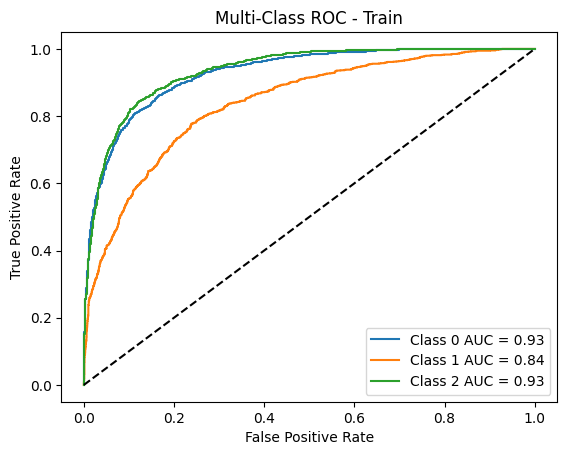

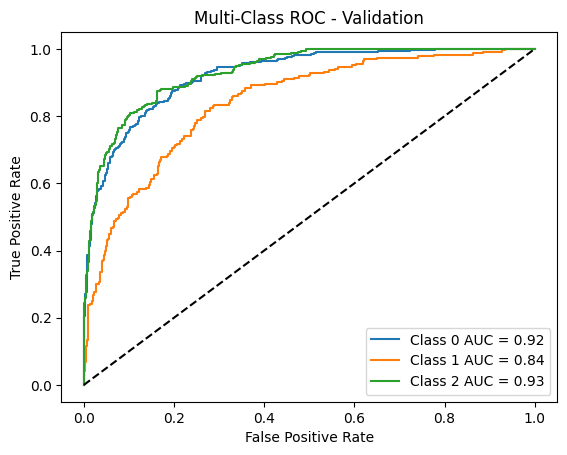

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

target = 'MatchResult'
features = [col for col in df_train.columns if col != target]
X_train = df_train[features]
y_train = df_train[target]
X_val = df_val[features]
y_val = df_val[target]
model = LogisticRegression(max_iter=1000, multi_class='ovr')
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_prob_train = model.predict_proba(X_train)
y_pred_val = model.predict(X_val)
y_prob_val = model.predict_proba(X_val)
print("BA(Train):", round(balanced_accuracy_score(y_train, y_pred_train), 4))
print("BA (Validation):", round(balanced_accuracy_score(y_val, y_pred_val), 4))
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
y_train_bin = label_binarize(y_train, classes=[0, 1, 2])
y_val_bin = label_binarize(y_val, classes=[0, 1, 2])
def plot_multi_class_roc(y_true_bin, y_prob, dataset_label):
    plt.figure()
    for i in range(3):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} AUC = {roc_auc:.2f}')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'Multi-Class ROC - {dataset_label}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
plot_multi_class_roc(y_train_bin, y_prob_train, 'Train')
plot_multi_class_roc(y_val_bin, y_prob_val, 'Validation')

BA(Train - RF): 0.681
BA(Validation - RF): 0.6361


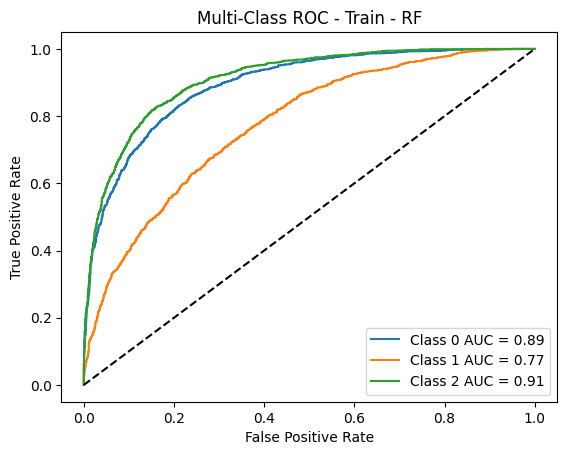

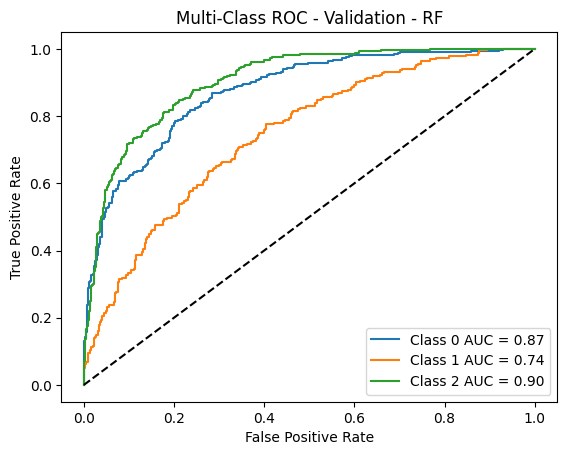

In [40]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=3,
    min_samples_split=2,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train, y_train)
y_pred_train_rf = rf_model.predict(X_train)
y_prob_train_rf = rf_model.predict_proba(X_train)
y_pred_val_rf = rf_model.predict(X_val)
y_prob_val_rf = rf_model.predict_proba(X_val)
print("BA(Train - RF):", round(balanced_accuracy_score(y_train, y_pred_train_rf), 4))
print("BA(Validation - RF):", round(balanced_accuracy_score(y_val, y_pred_val_rf), 4))
plot_multi_class_roc(y_train_bin, y_prob_train_rf, 'Train - RF')
plot_multi_class_roc(y_val_bin, y_prob_val_rf, 'Validation - RF')


/Users/marcoayuob/anaconda3/envs/shap_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:59:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/marcoayuob/anaconda3/envs/shap_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:59:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


BA (Train - XGB): 0.7863
BA (Validation - XGB): 0.7037


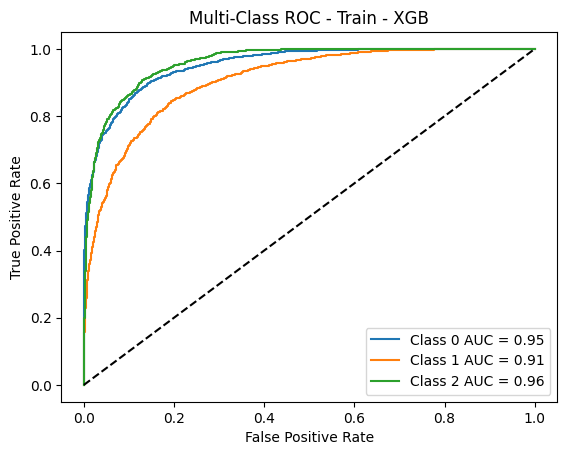

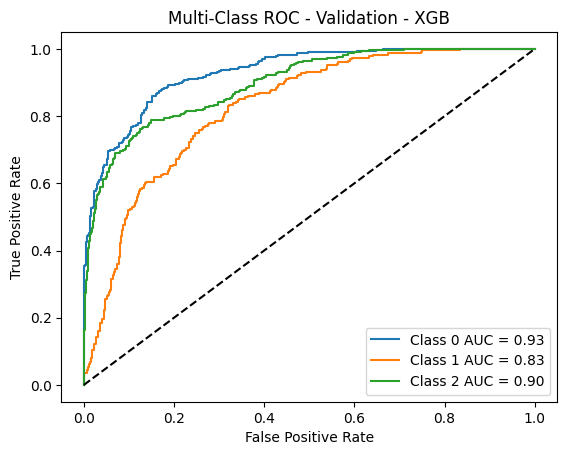

In [41]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=2,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='multi:softprob',
    num_class=3,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
y_pred_train_xgb = xgb_model.predict(X_train)
y_prob_train_xgb = xgb_model.predict_proba(X_train)
y_pred_val_xgb = xgb_model.predict(X_val)
y_prob_val_xgb = xgb_model.predict_proba(X_val)
print("BA (Train - XGB):", round(balanced_accuracy_score(y_train, y_pred_train_xgb), 4))
print("BA (Validation - XGB):", round(balanced_accuracy_score(y_val, y_pred_val_xgb), 4))
plot_multi_class_roc(y_train_bin, y_prob_train_xgb, 'Train - XGB')
plot_multi_class_roc(y_val_bin, y_prob_val_xgb, 'Validation - XGB')

BA (Train - XGB): 0.7863
BA(Test - XGB): 0.6897


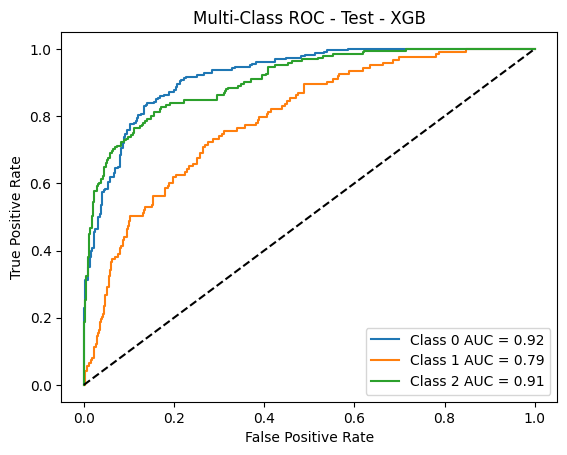

In [42]:
X_test = df_test[features]
y_test = df_test[target]
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_pred_test_xgb = xgb_model.predict(X_test)
y_prob_test_xgb = xgb_model.predict_proba(X_test)
print("BA (Train - XGB):", round(balanced_accuracy_score(y_train, y_pred_train_xgb), 4))
print("BA(Test - XGB):", round(balanced_accuracy_score(y_test, y_pred_test_xgb), 4))
plot_multi_class_roc(y_test_bin, y_prob_test_xgb, 'Test - XGB')

BA(Train - RF): 0.681
BA(Test - RF): 0.6269


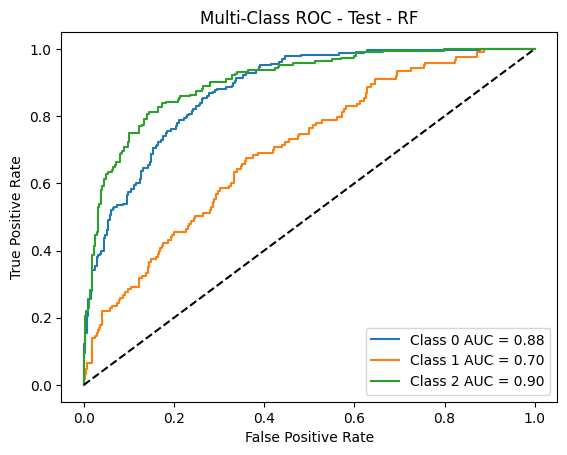

In [43]:
y_pred_test_rf = rf_model.predict(X_test)
y_prob_test_rf = rf_model.predict_proba(X_test)
print("BA(Train - RF):", round(balanced_accuracy_score(y_train, y_pred_train_rf), 4))
print("BA(Test - RF):", round(balanced_accuracy_score(y_test, y_pred_test_rf), 4))
plot_multi_class_roc(y_test_bin, y_prob_test_rf, 'Test - RF')

BA (Train - Logistic): 0.732
BA (Test - Logistic): 0.7407


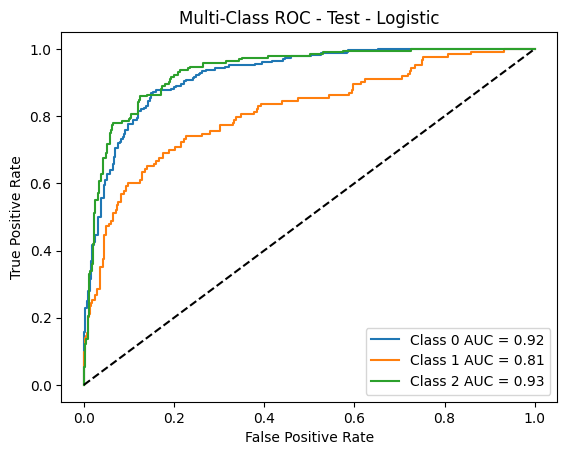

In [44]:
y_pred_test = model.predict(X_test)
y_prob_test = model.predict_proba(X_test)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
print("BA (Train - Logistic):", round(balanced_accuracy_score(y_train, y_pred_train), 4))
print("BA (Test - Logistic):", round(balanced_accuracy_score(y_test, y_pred_test), 4))
plot_multi_class_roc(y_test_bin, y_prob_test, 'Test - Logistic')

/Users/marcoayuob/anaconda3/envs/shap_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


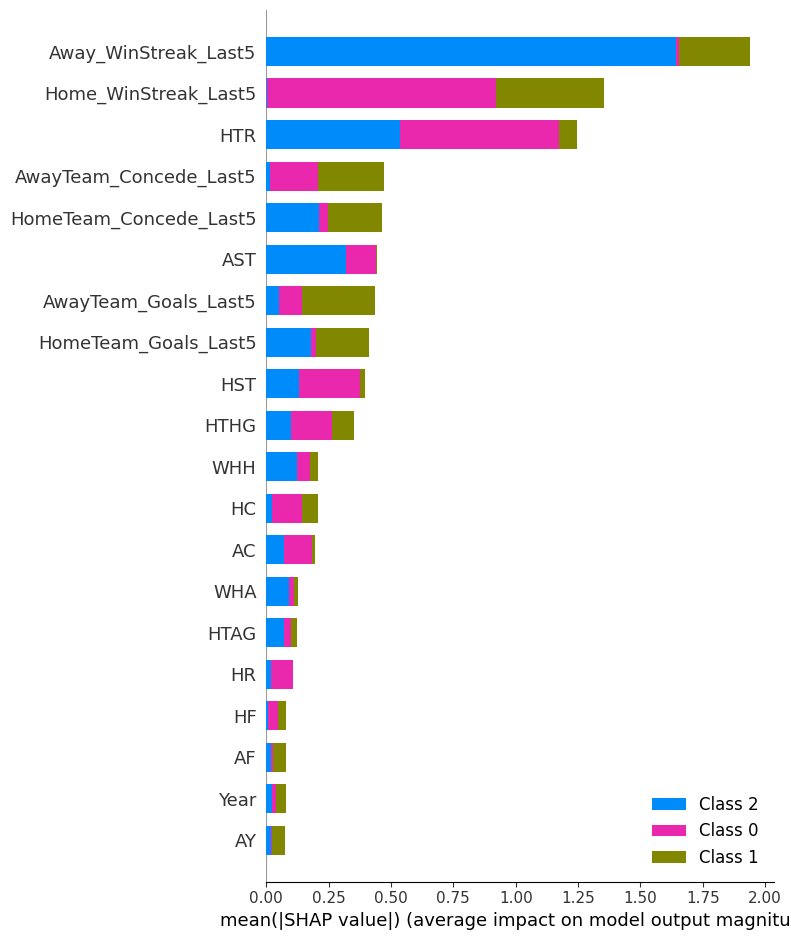

In [45]:
import shap
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")